In [2]:
# convert the <start> <end> to the '$'
f2 = open('./data/input2.txt', 'a')

with open('./data/input.txt', 'rw') as f:
    line = f.readline()
    while line:
        # print repr(line)
        if '<start>' in line:
            f2.write('$\r\n')
        elif '<end>' not in line:
            f2.write(line)
        line = f.readline()

In [3]:
f2.close()

以上两块生成新的文件，我把start 和end统一改成了'$'，跑一遍就行了

In [3]:
torch.cuda.is_available()

True

In [4]:
with open('./data/input2.txt', 'r') as f:
    s_all = f.read()
    
# s1 = 
# seq_len = 25
# i = 0
# data = []
# while i + 25 < len(s):
#     data.append(list(s[i:i+25]))
#     i += 25

In [5]:
from collections import Counter
counter = Counter(s_all)
letter2int = {}
i = 0
for k, v in counter.most_common():
    letter2int[k] = i
    i += 1

In [6]:
n_letters = len(letter2int)

In [7]:
len(letter2int)

95

In [8]:
len(s_all)

505570

In [9]:
import torch
import torch.nn as nn
from torch import autograd
from torch import optim
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

In [10]:
class LSTM_RNN(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_layers, batch_size, drop_out):
        super(LSTM_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_layers = n_layers

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_out)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # self.hidden = self.init_hidden()

    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim)).cuda(),
                autograd.Variable(torch.zeros(self.n_layers, batch_size, self.hidden_dim)).cuda())

    def forward(self, sentence,hidden):
        batch_size = sentence.size()[1]
        seq_lens = sentence.size()[0]
        
        embeds = self.word_embeddings(sentence)
        hidden = repackage(hidden)
        lstm_out, hidden = self.lstm(
            embeds.view(seq_lens, batch_size, -1), hidden)
        tag_space = self.hidden2tag(lstm_out.view(seq_lens * batch_size, -1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores, hidden
    

In [11]:
def repackage(h):
    if type(h) == autograd.Variable:
        return autograd.Variable(h.data)
    else:
        return tuple(repackage(v) for v in h)

In [12]:
s_train = s_all[:int(len(s_all) * 0.8)]
s_valid = s_all[int(len(s_all) * 0.8):]

In [13]:
int(len(s_all) * 0.8) / 64

6319

In [14]:
len(s_train)

404456

In [15]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return idxs

def batch_generator(batch_size, chunk_size, s):
    i = 0
    data = []
    while i + chunk_size * batch_size < len(s) - 1:
        lines1 = []
        lines2 = []
        for j in range(batch_size):
            lines1.append(s[i + j * chunk_size: i + (j + 1) * chunk_size])
            lines2.append(s[i + j * chunk_size + 1: i + (j + 1) * chunk_size + 1])
        X = [prepare_sequence(l, letter2int) for l in lines1]
        y = [prepare_sequence(l, letter2int) for l in lines2]
        X = np.array(X).transpose(1,0)
        y = np.array(y).transpose(1,0)
        X = torch.LongTensor(X)
        y = torch.LongTensor(y)
        i += chunk_size * batch_size
        X = autograd.Variable(X.cuda())
        y = autograd.Variable(y.cuda())
        yield X, y

In [16]:
# count = 0
# for a, b in batch_generator(64, 25, s_train):
#     print a.size()
#     count += 1
# print count

In [17]:
len(s_train) / (64 * 25)

252

In [81]:
EMBEDDING_DIM = 64
dim = 95
HIDDEN_DIM = 100
batch_size = 100
chunk_size = 25
n_layers = 1
n_epochs = 300
dropout = 0

In [82]:
n_train_batch = len(s_train) / (64 * 25)
n_valid_batch = len(s_valid) / (64 * 25)

In [83]:
model = LSTM_RNN(EMBEDDING_DIM, HIDDEN_DIM, n_letters, n_letters, n_layers, batch_size, dropout)
model = model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

In [84]:
record = [0, 0, 0]
last_valid_loss = 100000

## Train/Validation Error

In [85]:
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
#inputs = prepare_sequence(training_data[0][0], word_to_ix)
# tag_scores = model(inputs)
# print(tag_scores)

train_loss = []
validation_loss = []

for epoch in range(n_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    print 'epoc = %d' %(epoch)
    
    losses = 0
    hidden = model.init_hidden(batch_size)
    for X, y in batch_generator(batch_size, chunk_size, s_train):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        # targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores, hidden = model(X, hidden) # X - 25 * 64,
        tag_scores = tag_scores.view(-1, dim).cuda() 
        y = y.contiguous().view(-1).cuda() # convert label y to contiguous

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(tag_scores, y)
        loss.backward()
        optimizer.step()
        
        losses += loss.data[0]
    
    losses_valid = 0 
    for X, y in batch_generator(batch_size, chunk_size, s_valid):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        # targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores, hidden = model(X, hidden)
        tag_scores = tag_scores.view(-1, dim).cuda()
        y = y.contiguous().view(-1).cuda()

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(tag_scores, y)
        losses_valid += loss.data[0]
    
    train_loss.append(losses/n_train_batch)
    validation_loss.append(losses_valid/n_valid_batch)
    
    record = record[1:]
    if losses_valid < last_valid_loss:
        record.append(1)
    else:
        record.append(-1)
    if sum(record) == -3:
        print 'early stopped'
        break
    last_valid_loss = losses_valid
        
#     print 'training:', losses / n_train_batch
#     print 'valid:', losses_valid / n_valid_batch

# See what the scores are after training
# inputs = prepare_sequence(training_data[0][0], word_to_ix)
# tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
# print(tag_scores)

epoc = 0
epoc = 1
epoc = 2
epoc = 3
epoc = 4
epoc = 5
epoc = 6
epoc = 7
epoc = 8
epoc = 9
epoc = 10
epoc = 11
epoc = 12
epoc = 13
epoc = 14
epoc = 15
epoc = 16
epoc = 17
epoc = 18
epoc = 19
epoc = 20
epoc = 21
epoc = 22
epoc = 23
epoc = 24
epoc = 25
epoc = 26
epoc = 27
epoc = 28
epoc = 29
epoc = 30
epoc = 31
epoc = 32
epoc = 33
epoc = 34
epoc = 35
epoc = 36
epoc = 37
epoc = 38
epoc = 39
epoc = 40
epoc = 41
epoc = 42
epoc = 43
epoc = 44
epoc = 45
epoc = 46
epoc = 47
epoc = 48
epoc = 49
epoc = 50
epoc = 51
epoc = 52
epoc = 53
epoc = 54
epoc = 55
epoc = 56
epoc = 57
epoc = 58
epoc = 59
epoc = 60
epoc = 61
epoc = 62
epoc = 63
epoc = 64
epoc = 65
epoc = 66
epoc = 67
epoc = 68
epoc = 69
epoc = 70
epoc = 71
epoc = 72
epoc = 73
epoc = 74
epoc = 75
epoc = 76
epoc = 77
epoc = 78
epoc = 79
epoc = 80
epoc = 81
epoc = 82
epoc = 83
epoc = 84
epoc = 85
epoc = 86
epoc = 87
epoc = 88
epoc = 89
epoc = 90
epoc = 91
epoc = 92
epoc = 93
epoc = 94
epoc = 95
epoc = 96
epoc = 97
epoc = 98
epoc = 99
epoc = 100

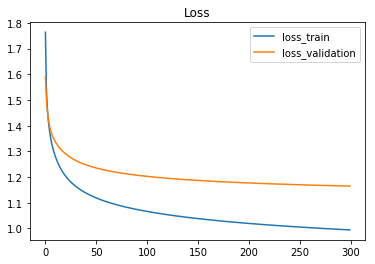

In [86]:
plt.figure()
plt.title('Loss')
plt.plot(train_loss, label='loss_train')
plt.plot(validation_loss, label='loss_validation')
plt.legend()
plt.show()

In [25]:
int2letter = {val: key for key, val in letter2int.items()}

In [26]:
def prepare_sequence2(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor

In [27]:
def generate(model, prime_str='$', predict_len=100, temperature=0.5):
    hidden = model.init_hidden(1)
    prime_input = prepare_sequence2(prime_str*1, letter2int)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = autograd.Variable(prime_input.cuda())
    inp = inp.view(1,-1)
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        # return top_i
        # Add predicted character to string and use as next input
        temp = int2letter[top_i[0]]
        if temp=="$":
            break
        predicted += temp
        inp = autograd.Variable(prepare_sequence2(temp, letter2int).cuda())
        inp = inp.view(1,-1)

    return predicted

In [125]:
pred = generate(model, prime_str='$', predict_len=1000, temperature=0.5)
print pred

$
X:1
T:Polka
Z:id:hn-hornpipe-8
M:C|
K:D
d2 dc|B2G A2A|BAB cde|dBA BAG|ABc d2B|AFA ABc|ed ec|de cB|cB AF|AF G2:|
|: e2 ed|c2 BA|B/e/d/e/|dB AG|Ad cB|AG FA|FG AB|cA AB|ce dB|B2 A2:|
|:ag af|ag ag|agf gfe|def gfe|dBc dBA|1 BGA dBA|GBd gdB|cA AF|AF G2:|
|:ga af|gf ef|ed ed|e2 g>f|ed cB|AF/A/ AG|FE EF|G2 AB|d2 d2 d2|e2 ge|fe dB|AB c/d/ ed|cd/e/ de|fe fg|
ef ed/B/|AF GB|AF GF/G/|BA G2:|

